# Photometry

On this page we'll detect sources and perform photometry (along other measurements) for each pre-reduced image.
The procedure could also be applied to coadded images.

As before, you could copy or write the code shown below in a script, or alternatively directly download this page as a {download}`jupyter notebook <./photometry.ipynb>` file.

To run the code, you'll need the module `dataredconfig.py`, as explained [here](./data.md).

Potential improvements: PSF homogeneization, or go for PSF-fitting, should be beneficial for crowded clusters...

In [15]:
import dataredconfig
from pathlib import Path

import numpy as np
import astropy
import astropy.visualization
from astropy import units as u

%matplotlib widget
import matplotlib
from matplotlib import pyplot as plt

import ccdproc
import photutils

In [38]:
# Locating the pre-reduced science images:

object_to_process = "M 37"

light_prered_dir = dataredconfig.work_dir / "LIGHT_PRERED"
science_files = ccdproc.ImageFileCollection(light_prered_dir, keywords=dataredconfig.ifc_header_keywords)

science_files = science_files.filter(object=object_to_process)

# Overview of all available files:
science_files.summary

/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits" contains multiple entries for "__order", the pair "__order=3.0" will be ignored.
  warnings.warn(
/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits" contains multiple entries for "_p_order", the pair "_p_order=3.0" will be ignored.
  warnings.warn(
/Users/mtewes/miniconda3/envs/datared2/lib/python3.11/site-packages/ccdproc/image_collection.py:548: UserWarning: Header from file "/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-05-37_r_-10.00_60.00s_0001.fits" contains multiple entries for "__order", the pair "__order=3.0" will be i

file,imagetyp,filter,exptime,object,xbinning,ybinning,naxis1,naxis2
str109,str5,str1,float64,str4,int64,int64,int64,int64
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-04-34_r_-10.00_60.00s_0000.fits,LIGHT,r,60.0,M 37,2,2,4788,3194
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-05-37_r_-10.00_60.00s_0001.fits,LIGHT,r,60.0,M 37,2,2,4788,3194
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-06-39_r_-10.00_60.00s_0002.fits,LIGHT,r,60.0,M 37,2,2,4788,3194
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-07-43_g_-10.00_60.00s_0000.fits,LIGHT,g,60.0,M 37,2,2,4788,3194
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-08-45_g_-10.00_60.00s_0001.fits,LIGHT,g,60.0,M 37,2,2,4788,3194
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-09-47_g_-10.00_60.00s_0002.fits,LIGHT,g,60.0,M 37,2,2,4788,3194
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-10-51_i_-10.00_60.00s_0000.fits,LIGHT,i,60.0,M 37,2,2,4788,3194
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-11-53_i_-9.90_60.00s_0001.fits,LIGHT,i,60.0,M 37,2,2,4788,3194
/Users/mtewes/Desktop/no_backup/workdir_2024-03-08/LIGHT_PRERED/2024-03-08_22-12-55_i_-10.00_60.00s_0002.fits,LIGHT,i,60.0,M 37,2,2,4788,3194


We will measure photometry on all these files.
But we start by picking one reference image, used to detect sources and to check the overall procedure. 

In [17]:
ref_image = ccdproc.CCDData.read(science_files.files[-1])

## Estimating and subtracting the background

Some of the following tasks will be run on several images, and we therefore define them as very simple functions.
Of course, depending on the data to be processed, you might want to adjust (hard-coded) parameters in these functions. They are only provided as examples.

In [18]:
def estimate_background(image):
    """Function to estimate the background (in form of an image),
    and the root-mean-square deviation (RMS) of the background.
    
    Parameters:
    image: a CCDData object

    Returns:
    background, background_rms: two numpy arrays
    """
    
    bkg = photutils.background.Background2D(
        image.data,
        box_size=(500, 500),
        filter_size=(3, 3),
        bkg_estimator=photutils.background.MedianBackground())
    
    return bkg.background, bkg.background_rms


In [19]:
# We run this on the reference image
background, background_rms = estimate_background(ref_image)

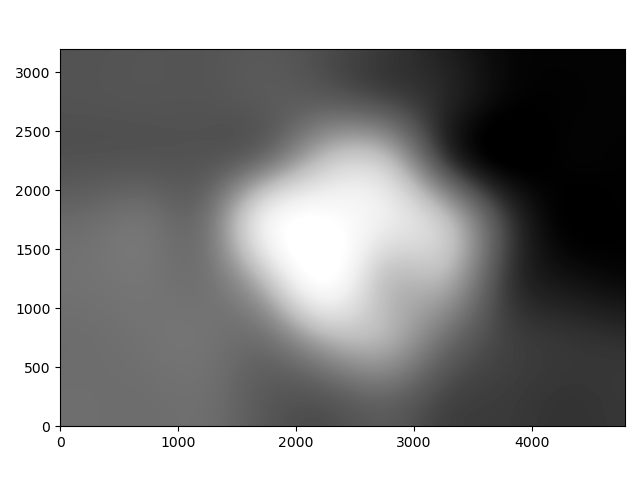

In [20]:
# Visualize the background image
plt.figure()
plt.imshow(background, origin='lower', cmap='Greys_r', interpolation='nearest')
plt.tight_layout()
plt.show()

In [21]:
# We subtract the background from the reference image
ref_image_noback = ref_image.subtract(ccdproc.CCDData(background, unit="adu"))

# And we define a "threshold" image for this reference frame,
# whose values are multiples of the estimated RMS of the background in each pixel.
# (RMS is an estimate of the standard deviation, so 3*RMS is "3 sigma" above the background)
threshold = 3.0 * background_rms # this is an array

## Source detection and measurement

We now detect sources (as groups of connected pixels above the threshold) and measure their exact positions (among other parameters), on the selected reference image. Let's nevertheless group all this in a function again.

In [22]:
def detect_and_measure(image, threshold):
    """Function to detect and measure sources.
    This is close to what Source Extractor typically does.
    
    Parameters:
    image: a CCDData object
    threshold: a 2D-array with threshold values

    Returns:
    An Astropy Table with source positions (from  windowed centroids, 
    both in pixel and sky coordinates) and other measurements.
    """
    data = image.data 

    # Filtering (convolving with a 2D Gaussian) for better source detection
    kernel = photutils.segmentation.make_2dgaussian_kernel(fwhm=4.0, size=21)  # FWHM in pixels
    convolved_data = astropy.convolution.convolve(data, kernel)

    # Segmenting the image
    finder = photutils.segmentation.SourceFinder(npixels=4, connectivity=4, progress_bar=False)
    segment_map = finder(convolved_data, threshold)
    #segment_map = finder(data, threshold) # One could also run this on the unfiltered image

    # And measuring sources
    source_catalog = photutils.segmentation.SourceCatalog(data, segment_map, convolved_data=convolved_data, wcs=image.wcs)
    source_table = source_catalog.to_table(
        columns=["xcentroid_win", "ycentroid_win", "sky_centroid_win",
                 "fwhm", "max_value", "kron_flux", "segment_flux", "segment_area"]
        )

    return astropy.table.Table(source_table) # We convert the QTable to a Table, better for later FITS writing.

In [32]:
# Run this on the reference image
ref_catalog = detect_and_measure(ref_image_noback, threshold)

print(f"Reference catalog: {len(ref_catalog)} sources detected.")

Reference catalog: 3924 sources detected.


After running a detection, it's almost mandatory to check the result with a visualization! We do this with the following interactive Figure.

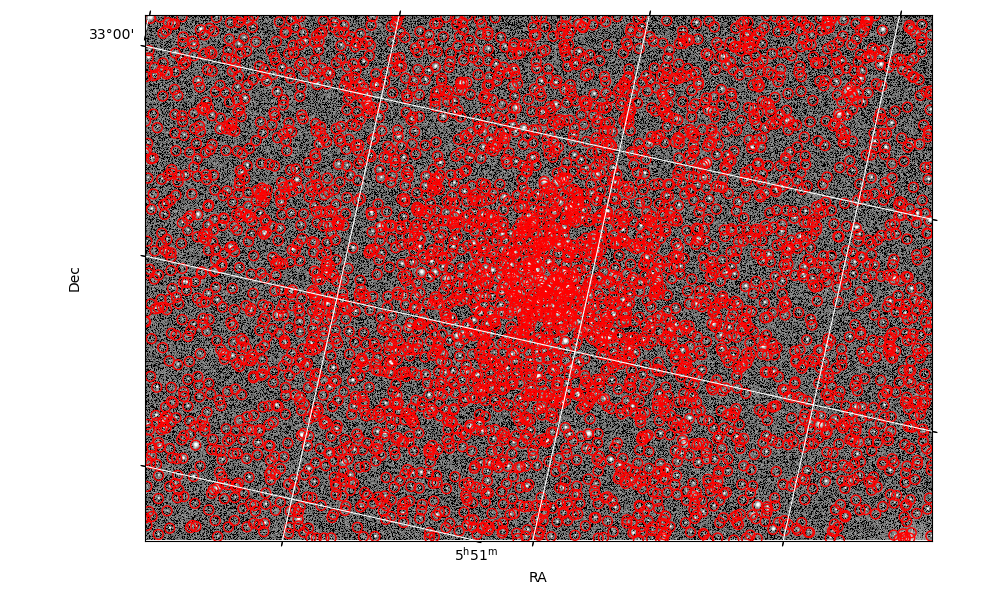

In [24]:
# Figure that overplots the image and the positions of the detected sources

plt.figure(figsize=(10, 6))
ax = plt.subplot(projection=ref_image_noback.wcs)
ax.imshow(ref_image_noback.data, origin='lower', cmap='Greys_r', interpolation='nearest',
    norm=astropy.visualization.simple_norm(ref_image_noback.data, stretch="log", min_cut=-20, max_cut=2000))
ax.scatter(
    ref_catalog["xcentroid_win"],
    ref_catalog["ycentroid_win"],
    transform=ax.get_transform('pixel'),
    s=50, # The size of these markers is not related to any measurement apertures!
    edgecolor='red', facecolor='none'
    )
ax.grid(color='white', ls='solid')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.tight_layout()
plt.show()

Zoom in and check if all relevant sources are detected. If there are issues, one might have to adjust the sensitivity of the detection.

In [33]:
# Make this catalog smaller, for testing:
ref_catalog = ref_catalog[ref_catalog["kron_flux"] > 10000] # pick the brightest sources
len(ref_catalog)

2419

## Forced aperture photometry

We'll now perform forced aperture photometry on all science images of our target.
This means that we use the sky coordinates of the sources detected in the reference frame to place the same apertures on all dithered exposures of the target.

In [34]:
# We group all steps of the photometric measurement into one function:

def measure_photometry(image, sky_positions):
    """Function for forced aperture photometry given the provided sky_positions.
    This is somehow similar to running Source Extractor in "dual image mode".

    Parameters:
    image: a CCDData object
    sky_positions: a list or column of aperture positions, in sky coordinates (i.e. as SkyCoord objects)

    Returns:
    An Astropy Table with measurements for several aperture radii at the given positions.
    """

    # Estimate and subtract the background:
    background, _ = estimate_background(image)
    image_noback = image.subtract(ccdproc.CCDData(background, unit="adu"))
    
    aperture_radii = [4, 6, 8] # In arcsec

    # We first generate a separate catalog for each aperture radius, and combine these afterwards
    aperture_catalogs = []
    for r in aperture_radii:

        apertures = photutils.aperture.SkyCircularAperture(sky_positions, r=r*u.arcsec)
        aperture_measurements = photutils.aperture.ApertureStats(image_noback.data, aperture=apertures, wcs=image_noback.wcs)
        aperture_catalog = aperture_measurements.to_table(columns=["fwhm", "elongation", "sum"])

        # Rename columns by adding the aperture radius, to get for example "sum_4" instead of sum
        for name in aperture_catalog.colnames:
            aperture_catalog.rename_column(name, new_name=f"{name}_{str(r)}")
        
        aperture_catalogs.append(aperture_catalog)
    
    # And now merge these catalogs into a single one:
    merged_catalog = astropy.table.hstack(aperture_catalogs,
        join_type="exact", metadata_conflicts="silent"
        )
    return merged_catalog


In [35]:

# As a test, we run this on the ref_image:
ref_photo_cat = measure_photometry(ref_image, ref_catalog["sky_centroid_win"])
print(ref_photo_cat.colnames)

['fwhm_4', 'elongation_4', 'sum_4', 'fwhm_6', 'elongation_6', 'sum_6', 'fwhm_8', 'elongation_8', 'sum_8']


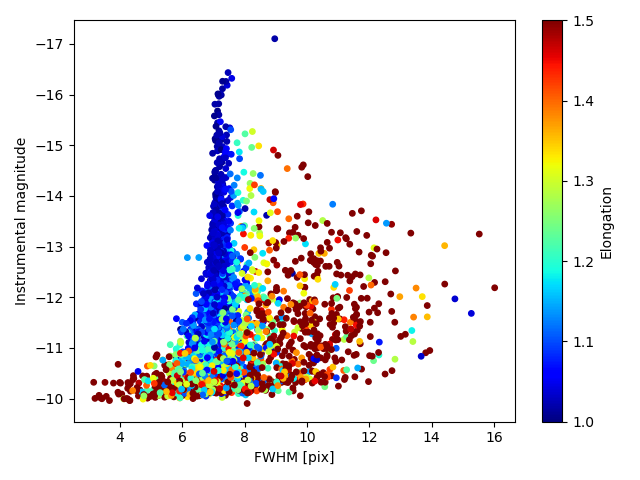

In [36]:
# Check plot of the aperture photometry catalog, magnitude versus size, stellar locus.

ref_photo_cat["mag_8"] = -2.5 * np.log10(ref_photo_cat["sum_8"].value)

plt.figure()
plt.scatter(
    ref_photo_cat["fwhm_8"].value, 
    ref_photo_cat["mag_8"], 
    c=ref_photo_cat["elongation_8"].value,
    vmin=1.0, vmax=1.5,
    cmap="jet",
    s=15
)
plt.gca().invert_yaxis()
plt.colorbar(label="Elongation")
plt.xlabel("FWHM [pix]")
plt.ylabel("Instrumental magnitude")
plt.tight_layout()
plt.show()

Finally, we apply this measurement function to all images of the object

In [39]:
# Where to write the catalogs:
photometry_dir = dataredconfig.work_dir / "PHOTOMETRY"
photometry_dir.mkdir(exist_ok=True)

# For reference, we write the reference catalog in this directory.
# It contains the aperture positions.
ref_catalog.write(photometry_dir / f"ref_catalog_{object_to_process}.fits", overwrite=True)

# And now we loop over all selected exposures:
for science_file in science_files.files:

    image_filename = Path(science_file).stem
    print(f"Running on {image_filename}...")

    image = ccdproc.CCDData.read(science_file)

    # We build a dict containing some meta-information of the image taken from the FITS header.
    # We'll later write this as meta-information of the catalogue.
    meta_from_image = {key: image.header[key] for key in [
        "DATE-OBS", "EXPTIME", "IMAGETYP", "AIRMASS", "PIERSIDE", "FILTER", "OBJECT",
        "FOCUSPOS", "FOCTEMP", "RA", "DEC", "SET-TEMP", "CCD-TEMP", "GAIN", "OFFSET"
        ]}
    
    # Now run the measurements:
    catalog = measure_photometry(image, ref_catalog["sky_centroid_win"])

    # Add the information from the FITS header
    catalog.meta.update(meta_from_image)

    # Copy a few columns from the reference catalog
    #catalog["sky_centroid_win"] = ref_catalog["sky_centroid_win"]

    # And write all this as a FITS table
    catalog.write(photometry_dir / f"{image_filename}.fits", overwrite=True)
    

Running on 2024-03-08_22-04-34_r_-10.00_60.00s_0000...


Running on 2024-03-08_22-05-37_r_-10.00_60.00s_0001...


Running on 2024-03-08_22-06-39_r_-10.00_60.00s_0002...


Running on 2024-03-08_22-07-43_g_-10.00_60.00s_0000...


Running on 2024-03-08_22-08-45_g_-10.00_60.00s_0001...


Running on 2024-03-08_22-09-47_g_-10.00_60.00s_0002...


Running on 2024-03-08_22-10-51_i_-10.00_60.00s_0000...


Running on 2024-03-08_22-11-53_i_-9.90_60.00s_0001...


Running on 2024-03-08_22-12-55_i_-10.00_60.00s_0002...
